In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE, ProjectionConfig

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:

(X,Y), (X_val,Y_val), axes = load_training_data('/run/media/sancere/DATA/Lucas_NextonCreated_npz/Training_CARE_projection_SpinwideFRAP_Bin1.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 44755
number of validation images:	 4973
image size (3D):		 (24, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


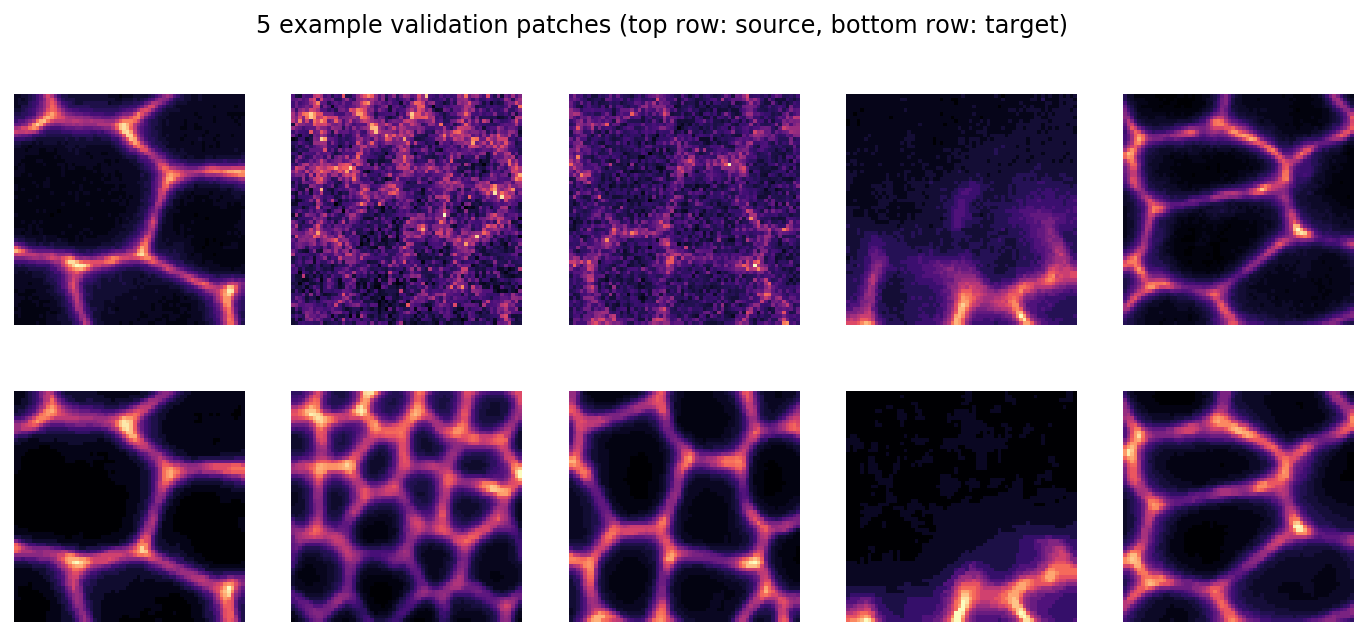

In [3]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [4]:
config = ProjectionConfig(axes, n_channel_in, n_channel_out, unet_n_depth=4,train_epochs= 150,train_steps_per_epoch = 120, train_batch_size = 100, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

ProjectionConfig(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, proj_axis='Z', proj_kern=(3, 3, 3), proj_n_conv_per_depth=1, proj_n_depth=4, proj_n_filt=8, proj_pool=(1, 2, 2), train_batch_size=100, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=150, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 5, 'factor': 0.5}, train_steps_per_epoch=120, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=4, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 4,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 150,
 'train_steps_per_epoch': 120,
 'train_learning_rate': 0.0004,
 'train_batch_size': 100,
 'train_tensorboard': True,
 'train_reduce_lr': {'patience': 5, 'factor': 0.5},
 'proj_axis': 'Z',
 'proj_n_depth': 4,
 'proj_n_filt': 8,
 'proj_n_conv_per_depth': 1,
 'proj_kern': (3, 3, 3),
 'proj_pool': (1, 2, 2)}

In [5]:
model = ProjectionCARE(config, 'CARE_projection_SpinwideFRAP4_Bin1', basedir='/home/sancere/NextonDisk_1/Lucas_Model_to_use/CARE/')
# model.load_weights(ModelDir + 'CARE_projection_Borealis_Bin2_AudeData_Second' + '/' + 'weights_best.h5')

In [6]:
history = model.train(X,Y, validation_data=(X_val,Y_val))










The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/150
120/120 [==============================] - 55s 455ms/step - loss: 0.0534 - mse: 0.0070 - mae: 0.0534 - val_loss: 0.0296 - val_mse: 0.0019 - val_mae: 0.0296

Epoch 2/150
120/120 [==============================] - 50s 415ms/step - loss: 0.0263 - mse: 0.0015 - mae: 0.0263 - val_loss: 0.0260 - val_mse: 0.0015 - val_mae: 0.0260
Epoch 3/150
120/120 [==============================] - 51s 426ms/step - loss: 0.0246 - mse: 0.0013 - mae: 0.0246 - val_loss: 0.0240 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 4/150
120/120 [==============================] - 49s 405ms/step - loss: 0.0243 - mse: 0.0013 - mae: 0.0243 - val_

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


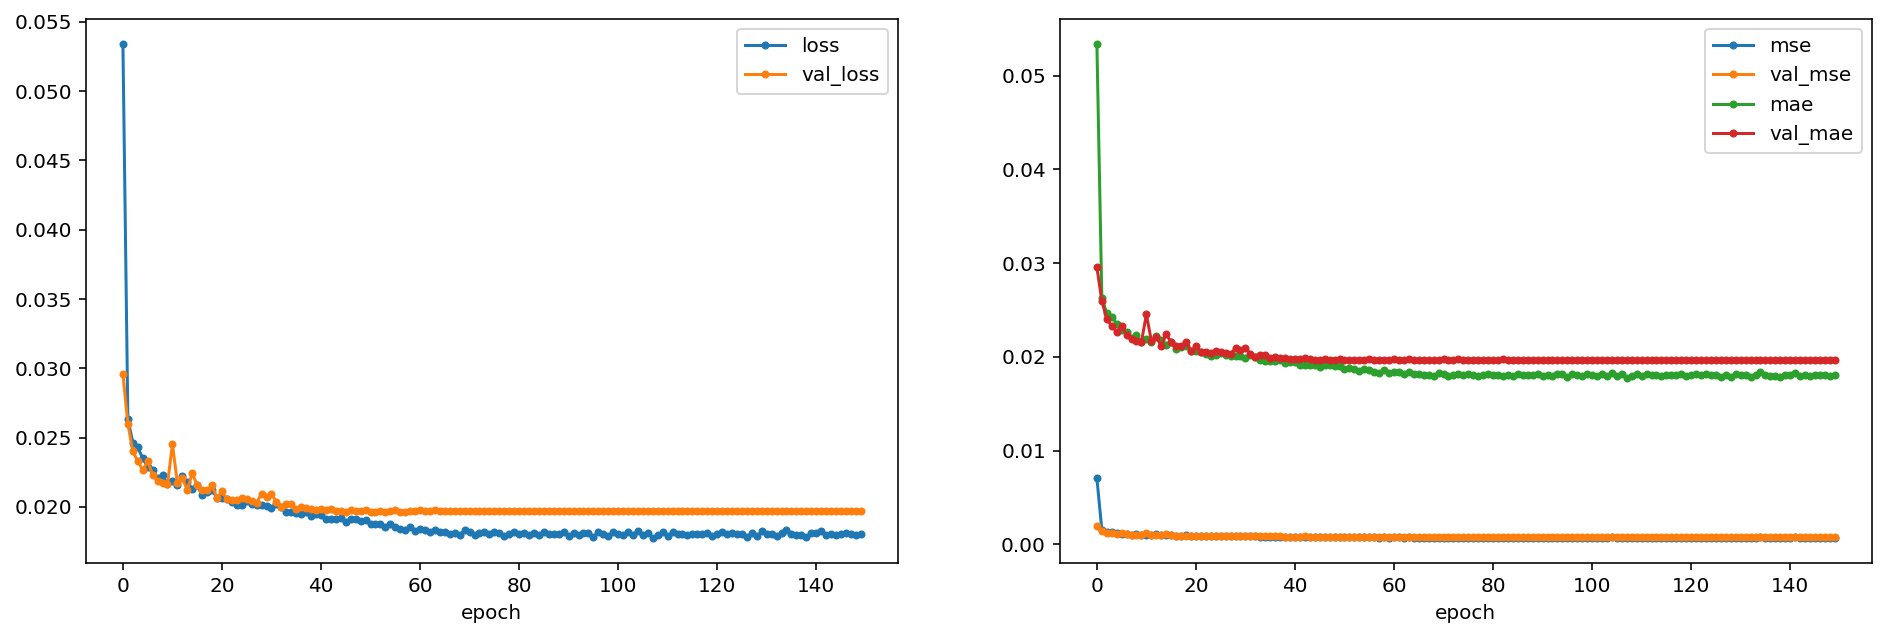

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

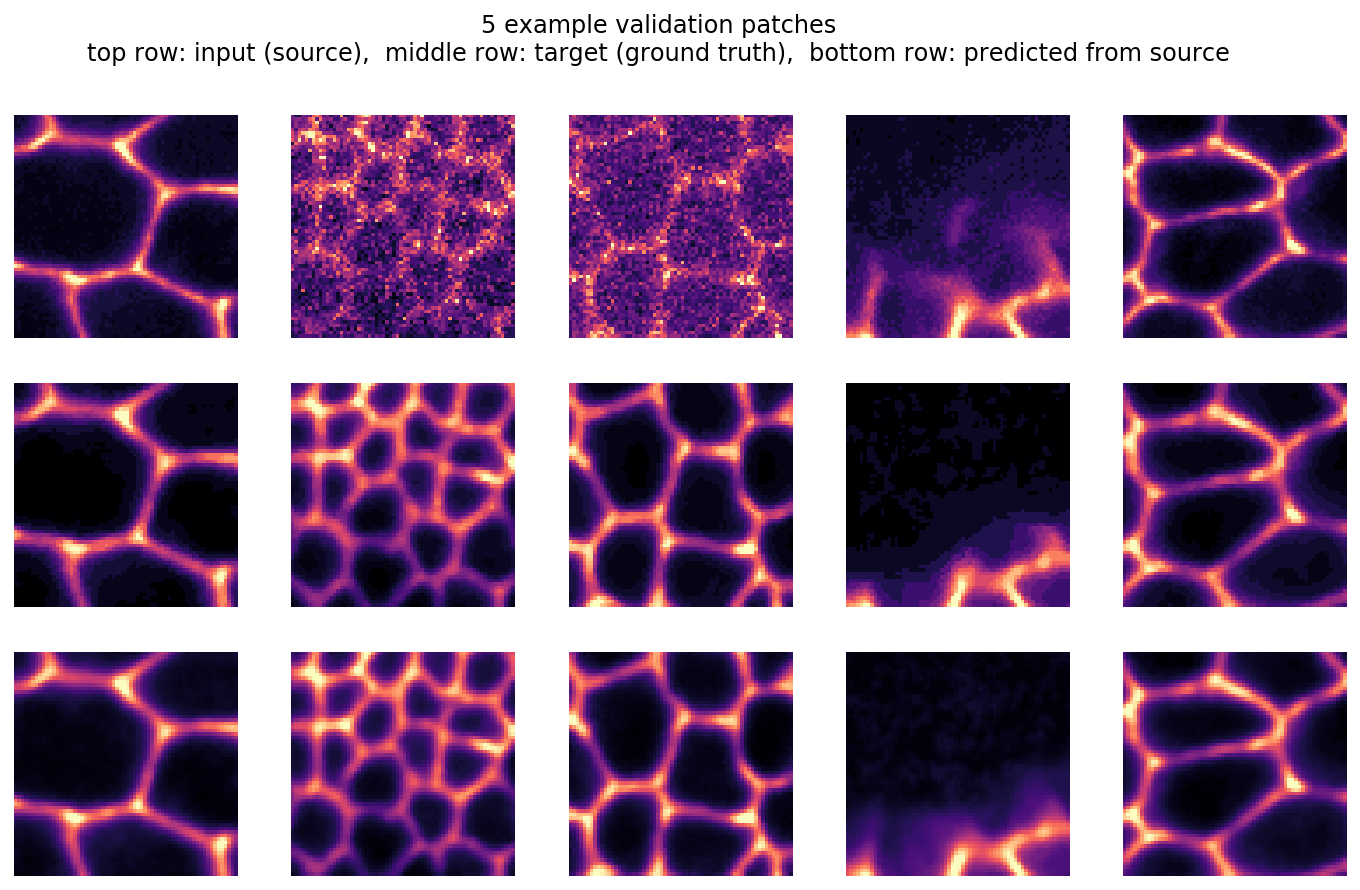

In [8]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [9]:
model.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp6h56u51u/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/sancere/NextonDisk_1/Lucas_Model_to_use/CARE/CARE_projection_SpinwideFRAP4_Bin1/TF_SavedModel.zip
